In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time
import math
from tqdm.auto import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [3]:
X_train, X_test, y_train, y_test = joblib.load("data/train_test_split.joblib")
preprocessor = joblib.load("models/preprocessor.joblib")

In [4]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train distribusi:")
print((y_train.value_counts(normalize=True) * 100).round(2))
print("\ny_test distribusi:")
print((y_test.value_counts(normalize=True) * 100).round(2))

X_train shape: (1163451, 18)
X_test shape : (290863, 18)
y_train distribusi:
Arrest
False    74.09
True     25.91
Name: proportion, dtype: float64

y_test distribusi:
Arrest
False    74.09
True     25.91
Name: proportion, dtype: float64


### Definisikan model-model yang akan dipakai (baseline)

In [5]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ),
    "DecisionTree": DecisionTreeClassifier(
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        n_estimators=200
    ),
    "XGBoost": XGBClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss", 
        n_jobs=-1
    )
}

print("Model yang akan diuji:", list(models.keys()))

Model yang akan diuji: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']


### Definisikan strategi sampling

In [6]:
sampling_strategies = {
    "none": None,
    "smote": SMOTE(random_state=42)
}

print("Strategi sampling:", list(sampling_strategies.keys()))

Strategi sampling: ['none', 'smote']


### Function: evaluasi & simpan metrik

In [7]:
def evaluate_classification(y_true, y_pred, y_proba=None, positive_label=1):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=positive_label)
    rec = recall_score(y_true, y_pred, pos_label=positive_label)
    f1 = f1_score(y_true, y_pred, pos_label=positive_label)

    auc = None
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
        except ValueError:
            auc = None

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

### Loop utama: Preprocessing + Sampling + Model dalam 1 pipeline

In [8]:
train_frac = 0.1

# Pastikan tidak lebih besar dari 1.0
train_frac = min(train_frac, 1.0)

# Hanya kalau memang mau dikurangi (kalau 1.0 berarti pakai seluruh training)
if train_frac < 1.0:
    X_train_small, _, y_train_small, _ = train_test_split(
        X_train,
        y_train,
        train_size=train_frac,
        stratify=y_train,
        random_state=42
    )

    print("=== Stratified subsampling dilakukan ===")
    print("Ukuran X_train awal :", X_train.shape[0])
    print("Ukuran X_train_small:", X_train_small.shape[0])
    print("\nDistribusi Arrest di y_train_small:")
    print((y_train_small.value_counts(normalize=True) * 100).round(2))

    # Kita akan pakai X_train_small & y_train_small untuk training
    X_train_used = X_train_small
    y_train_used = y_train_small
else:
    print("train_frac = 1.0, pakai seluruh X_train")
    X_train_used = X_train
    y_train_used = y_train

=== Stratified subsampling dilakukan ===
Ukuran X_train awal : 1163451
Ukuran X_train_small: 116345

Distribusi Arrest di y_train_small:
Arrest
False    74.09
True     25.91
Name: proportion, dtype: float64


In [9]:
results = []

positive_label = True if y_train.dtype == 'bool' else 1

# Bungkus loop luar/inner dengan tqdm
sampling_items = list(sampling_strategies.items())
model_items = list(models.items())

for samp_name, sampler in tqdm(sampling_items, desc="Sampling strategies"):
    for model_name, model in tqdm(model_items, desc=f"Models ({samp_name})", leave=False):
        print(f"\nTraining model: {model_name} | Sampling: {samp_name}")
        
        start_time = time.time()
        
        if sampler is None:
            clf = ImbPipeline(steps=[
                ('preprocess', preprocessor),
                ('model', model)
            ])
        else:
            clf = ImbPipeline(steps=[
                ('preprocess', preprocessor),
                ('sampling', sampler),
                ('model', model)
            ])
        
        try:
            clf.fit(X_train_used, y_train_used)
            y_pred = clf.predict(X_test)
            
            y_proba = None
            if hasattr(clf.named_steps['model'], "predict_proba"):
                y_proba = clf.predict_proba(X_test)[:, 1]
            
            metrics = evaluate_classification(
                y_test, y_pred, y_proba, positive_label=positive_label
            )
            
            elapsed = time.time() - start_time
            
            print(f"  -> F1={metrics['f1']:.4f} | "
                  f"Recall={metrics['recall']:.4f} | "
                  f"AUC={metrics['auc']:.4f}" if metrics['auc'] is not None else
                  f"  -> F1={metrics['f1']:.4f} | "
                  f"Recall={metrics['recall']:.4f} | AUC=-")
            
            result_row = {
                "model": model_name,
                "sampling": samp_name,
                "train_time_sec": elapsed,
                **metrics
            }
            results.append(result_row)
        
        except Exception as e:
            elapsed = time.time() - start_time
            print(f"  !! ERROR pada {model_name} dengan {samp_name}: {e}")
            result_row = {
                "model": model_name,
                "sampling": samp_name,
                "train_time_sec": elapsed,
                "accuracy": np.nan,
                "precision": np.nan,
                "recall": np.nan,
                "f1": np.nan,
                "auc": np.nan,
                "error": str(e)
            }
            results.append(result_row)

results_df = pd.DataFrame(results)
results_df

Sampling strategies:   0%|          | 0/2 [00:00<?, ?it/s]

Models (none):   0%|          | 0/5 [00:00<?, ?it/s]


Training model: LogisticRegression | Sampling: none
  -> F1=0.7499 | Recall=0.6513 | AUC=0.9049

Training model: DecisionTree | Sampling: none
  -> F1=0.7178 | Recall=0.6763 | AUC=0.8053

Training model: RandomForest | Sampling: none
  -> F1=0.7413 | Recall=0.6382 | AUC=0.8919

Training model: LightGBM | Sampling: none
[LightGBM] [Info] Number of positive: 30143, number of negative: 86202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3249
[LightGBM] [Info] Number of data points in the train set: 116345, number of used features: 1370
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259083 -> initscore=-1.050741
[LightGBM] [Info] Start training from score -1.050741


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  -> F1=0.7523 | Recall=0.6434 | AUC=0.9126

Training model: XGBoost | Sampling: none
  -> F1=0.7490 | Recall=0.6342 | AUC=0.9107


Models (smote):   0%|          | 0/5 [00:00<?, ?it/s]


Training model: LogisticRegression | Sampling: smote
  -> F1=0.7276 | Recall=0.7311 | AUC=0.9016

Training model: DecisionTree | Sampling: smote
  -> F1=0.7222 | Recall=0.6751 | AUC=0.8065

Training model: RandomForest | Sampling: smote
  -> F1=0.7421 | Recall=0.6500 | AUC=0.8921

Training model: LightGBM | Sampling: smote
[LightGBM] [Info] Number of positive: 86202, number of negative: 86202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.437136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60518
[LightGBM] [Info] Number of data points in the train set: 172404, number of used features: 3426
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  -> F1=0.7542 | Recall=0.6624 | AUC=0.9111

Training model: XGBoost | Sampling: smote
  -> F1=0.7464 | Recall=0.6451 | AUC=0.9052


,model,sampling,train_time_sec,accuracy,precision,recall,f1,auc
0,LogisticRegression,none,7.878553,0.887473,0.883797,0.651295,0.749939,0.904882
1,DecisionTree,none,48.333677,0.862217,0.764698,0.676270,0.717771,0.805341
2,RandomForest,none,107.117475,0.884609,0.884176,0.638211,0.741324,0.891915
3,LightGBM,none,5.682280,0.890251,0.905683,0.643386,0.752328,0.912646
4,XGBoost,none,11.609169,0.889873,0.914473,0.634243,0.749005,0.910714
5,LogisticRegression,smote,29.109242,0.858157,0.724073,0.731116,0.727578,0.901569
6,DecisionTree,smote,90.459598,0.865445,0.776384,0.675076,0.722194,0.806476
7,RandomForest,smote,198.789683,0.882928,0.864516,0.649981,0.742054,0.892111
8,LightGBM,smote,29.969157,0.888147,0.875526,0.662442,0.754223,0.911074
9,XGBoost,smote,41.239479,0.886424,0.885430,0.645085,0.746386,0.905174


### Analisis hasil Skenario I

In [10]:
results_sorted_f1 = results_df.sort_values(
    by=["f1", "recall", "precision"],
    ascending=False
).reset_index(drop=True)

print("Hasil Skenario I - diurutkan berdasarkan F1 (terbaik di atas):")
display(results_sorted_f1)

Hasil Skenario I - diurutkan berdasarkan F1 (terbaik di atas):


,model,sampling,train_time_sec,accuracy,precision,recall,f1,auc
0,LightGBM,smote,29.969157,0.888147,0.875526,0.662442,0.754223,0.911074
1,LightGBM,none,5.682280,0.890251,0.905683,0.643386,0.752328,0.912646
2,LogisticRegression,none,7.878553,0.887473,0.883797,0.651295,0.749939,0.904882
3,XGBoost,none,11.609169,0.889873,0.914473,0.634243,0.749005,0.910714
4,XGBoost,smote,41.239479,0.886424,0.885430,0.645085,0.746386,0.905174
5,RandomForest,smote,198.789683,0.882928,0.864516,0.649981,0.742054,0.892111
6,RandomForest,none,107.117475,0.884609,0.884176,0.638211,0.741324,0.891915
7,LogisticRegression,smote,29.109242,0.858157,0.724073,0.731116,0.727578,0.901569
8,DecisionTree,smote,90.459598,0.865445,0.776384,0.675076,0.722194,0.806476
9,DecisionTree,none,48.333677,0.862217,0.764698,0.676270,0.717771,0.805341


In [17]:
pivot_f1 = results_df.pivot_table(
    index="model",
    columns="sampling",
    values="f1"
)

pivot_f1_sorted = pivot_f1.sort_values(
    by="smote",
    ascending=False
)

print("F1-score per Model x Sampling:")
display(pivot_f1_sorted)

F1-score per Model x Sampling:


sampling,none,smote
model,,
LightGBM,0.752328,0.754223
XGBoost,0.749005,0.746386
RandomForest,0.741324,0.742054
LogisticRegression,0.749939,0.727578
DecisionTree,0.717771,0.722194


<Figure size 800x500 with 0 Axes>

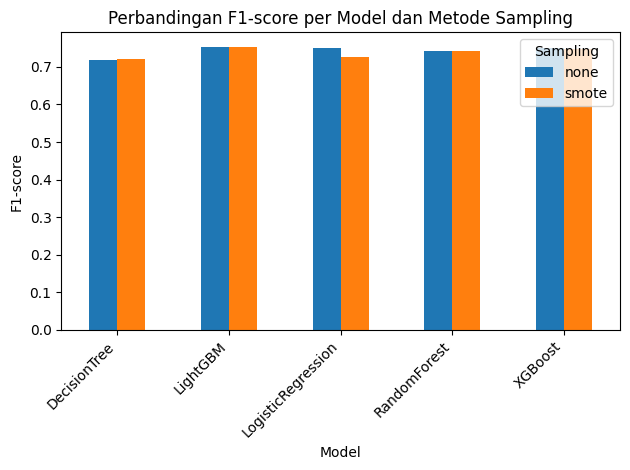

In [22]:
plt.figure(figsize=(8,5))
pivot_f1.plot(kind='bar')
plt.title('Perbandingan F1-score per Model dan Metode Sampling')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling')
plt.tight_layout()
plt.show()

In [18]:
pivot_auc = results_df.pivot_table(
    index="model",
    columns="sampling",
    values="auc"
)

pivot_auc_sorted = pivot_auc.sort_values(
    by="smote",
    ascending=False
)

print("AUC per Model x Sampling:")
display(pivot_auc_sorted)

AUC per Model x Sampling:


sampling,none,smote
model,,
LightGBM,0.912646,0.911074
XGBoost,0.910714,0.905174
LogisticRegression,0.904882,0.901569
RandomForest,0.891915,0.892111
DecisionTree,0.805341,0.806476


<Figure size 800x500 with 0 Axes>

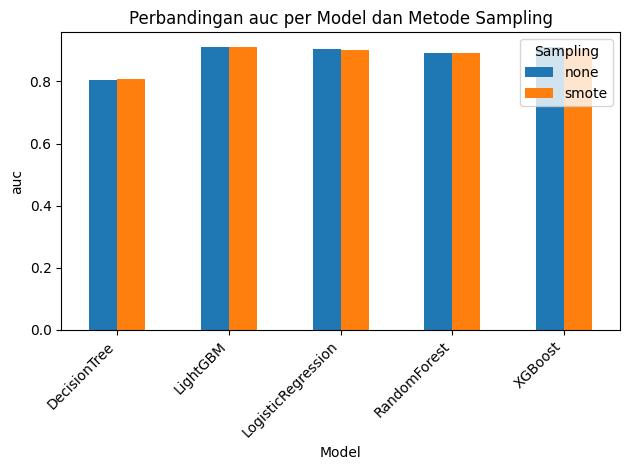

In [23]:
plt.figure(figsize=(8,5))
pivot_auc.plot(kind='bar')
plt.title('Perbandingan auc per Model dan Metode Sampling')
plt.xlabel('Model')
plt.ylabel('auc')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling')
plt.tight_layout()
plt.show()

In [14]:
best_row = results_sorted_f1.iloc[0]
best_model_name = best_row['model']
best_sampling_name = best_row['sampling']

print("Kombinasi terbaik berdasarkan F1 score:")
print(best_row)

best_model = models[best_model_name]
best_sampler = sampling_strategies[best_sampling_name]

if best_sampler is None:
    best_clf = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('model', best_model)
    ])
else:
    best_clf = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('sampling', best_sampler),
        ('model', best_model)
    ])

best_clf.fit(X_train, y_train)
y_pred_best = best_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
cm

Kombinasi terbaik berdasarkan F1 score:
model              LightGBM
sampling              smote
train_time_sec    29.969157
accuracy           0.888147
precision          0.875526
recall             0.662442
f1                 0.754223
auc                0.911074
Name: 0, dtype: object
[LightGBM] [Info] Number of positive: 862025, number of negative: 862025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 48.074265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89104
[LightGBM] [Info] Number of data points in the train set: 1724050, number of used features: 22519
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array([[207192,   8315],
       [ 24515,  50841]])

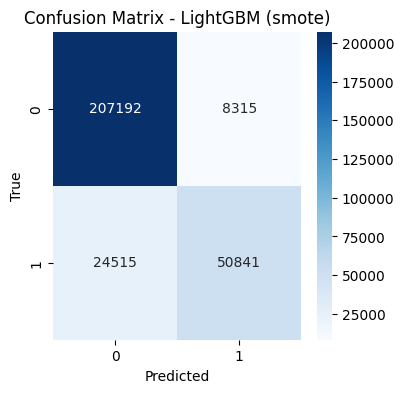

In [19]:
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} ({best_sampling_name})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Simpan hasil Skenario I

In [20]:
os.makedirs("results", exist_ok=True)
results_df.to_csv("results/skenario1_sampling_results.csv", index=False)

In [21]:
os.makedirs("models", exist_ok=True)
joblib.dump(best_clf, "models/skenario1_best_model.joblib")

['models/skenario1_best_model.joblib']